# Identification of Numeric Digits based on their image by using kNN and CNN

## --------------------------------------------------------------------------------------------------------------------------------

# Part 1: Introduction 

## The Street View House Numbers (SVHN) Dataset 

SVHN is a real-world image dataset for developing machine learning and object
recognition algorithms with minimal requirement on data formatting but comes from a
significantly harder, unsolved, real world problem (recognizing digits and numbers in
natural scene images). SVHN is obtained from house numbers in Google Street View
images.

## Goal 

The goal of this project is to take an image from the SVHN dataset and determine what that digit is. This is a multi-class classification problem with 10 classes, one for each digit 0-9. Digit '1' has label 1, '9' has label 9 and '0' has label 10.

## Objectives 

The objective of the project is to learn how to implement a simple image classification pipeline based on the k-Nearest Neighbour and a deep neural network. The goals of this assignment are as follows:

    ● Understand the basic Image Classification pipeline and the data-driven approach (train/predict stages)

    ● Data fetching and understand the train/val/test splits.

    ● Implement and apply an optimal k-Nearest Neighbor (kNN) classifier (7.5 points)

    ● Print the classification metric report (2.5 points)

    ● Implement and apply a deep neural network classifier including (feedforward neural network, RELU activations) (5 points)

    ● Understand and be able to implement (vectorized) backpropagation (cost stochastic gradient descent, cross entropy loss, cost functions) (2.5 points)

    ● Implement batch normalization for training the neural network (2.5 points)

# Part 2: Loading the dataset 

In [1]:
#Importing important modules
from __future__ import print_function
import numpy as np
import pandas as pd
from random import shuffle
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
import h5py
import numpy as np
import matplotlib.pyplot as plt
import cv2
from termcolor import colored
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy
import math
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import datasets
from skimage import exposure
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn import datasets
from skimage import exposure
import imutils
import sklearn
# handle older versions of sklearn
if int((sklearn.__version__).split(".")[1]) < 18:
	from sklearn.cross_validation import train_test_split
 
# otherwise we're using at lease version 0.18
else:
	from sklearn.model_selection import train_test_split
 
# load the MNIST digits dataset
mnist = datasets.load_digits()


%matplotlib inline

Using TensorFlow backend.


## Loading the training, test and validation sets

In [2]:
h5f = h5py.File('SVHN_single_grey1.h5', 'r')
x_train = h5f['X_train'][:]
y_train = h5f['y_train'][:]
x_test = h5f['X_test'][:]
y_test = h5f['y_test'][:]

h5f.close()

## Visualizing few images

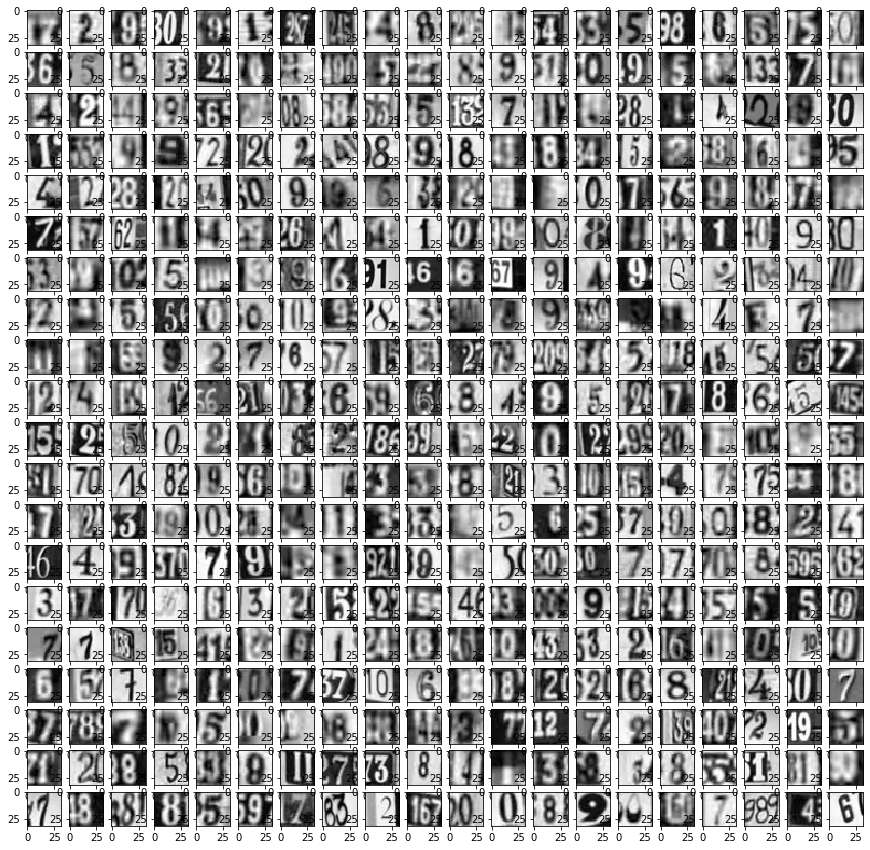

In [3]:
w=15
h=15
fig=plt.figure(figsize=(15, 15))
columns = 20
rows = 20
for i in range(1, columns*rows +1):
    img = x_test[i]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap='gray')

## Checking trainset's shape and data type 

In [4]:
print(x_train.shape)

(42000, 32, 32)


In [5]:
print(x_train.dtype)

float32


## Create a resized dataset for training and testing inputs to 28X28

In [6]:
x_train_res = np.zeros((x_train.shape[0],28,28), dtype=np.float32)
x_test_res = np.zeros((x_test.shape[0],28,28), dtype=np.float32)

## Resizing each train data to 28x28 using cv2.resize

In [7]:
for i in range(x_train.shape[0]):
    x_train_res[i,:,:] = cv2.resize(x_train[i], dsize=(28, 28), interpolation=cv2.INTER_CUBIC)

## Resizing each test data to 28x28 using cv2.resize

In [8]:
for i in range(x_test.shape[0]):
    x_test_res[i,:,:] = cv2.resize(x_test[i], dsize=(28, 28), interpolation=cv2.INTER_CUBIC)

## Clearing up memory

In [9]:
del x_train
del x_test

## Checking new test and train dataset's dataset shape 

In [10]:
print(x_train_res.shape)
print(x_test_res.shape)

(42000, 28, 28)
(18000, 28, 28)


## To be cpmpatible with Keras, we have to reshape the datasets

### Input Image dimensions 

In [11]:
img_rows, img_cols = 28, 28

### Keras expects data to be in the format (N_E.N_H,N_W,N_C)  N_E = Number of Examples, N_H = height, N_W = Width, N_C = Number of Channels.

In [12]:
x_train = x_train_res.reshape(x_train_res.shape[0], img_rows, img_cols, 1)
x_test = x_test_res.reshape(x_test_res.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

# Part 3: Data Pre-processing

## Setting dataset type as float32

In [13]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

## Normalizing 

In [14]:
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (42000, 28, 28, 1)
42000 train samples
18000 test samples


## Setting batch size, classes and epoch 

In [15]:
batch_size = 160
num_classes = 10
epochs = 7

In [16]:
print(y_train[4])

4


## Convert Labels from digits to one hot vectors 

In [17]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [18]:
print(y_train[4])

[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


# Part 4: Building the Neural Network 

## Initialize the model

In [19]:
model = Sequential()

## Setting activation function as 'ReLU' and adding a convolution layer with 32 filters and sie 3x3

In [20]:
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape,name='conv_1'))

Instructions for updating:
Colocations handled automatically by placer.


## Setting activation function as 'ReLU' and adding a convolution layer with 64 filters and sie 3x3

In [21]:
model.add(Conv2D(64, (3, 3), activation='relu',name='conv_2'))

## Add a MaxPooling Layer of size 2X2

In [22]:
model.add(MaxPooling2D(pool_size=(2, 2),name='max_1'))

## Apply Dropout with 0.25 probability 

In [23]:
model.add(Dropout(0.25,name='drop_1'))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


## Flatten the layer 

In [24]:
model.add(Flatten())

## Add Fully Connected Layer with 128 units and activation function as 'ReLU'

In [25]:
model.add(Dense(128, activation='relu',name='dense_1'))

## Apply Dropout with 0.5 probability

In [26]:
model.add(Dropout(0.5,name='drop_2'))

## Add Fully Connected Layer with 10 units and activation function as 'softmax'

In [27]:
model.add(Dense(num_classes, activation='softmax',name='dense_2'))

## Freezing layers in the model which don't have 'dense' in their name

In [28]:
for layer in model.layers:
    if('dense' not in layer.name):
        layer.trainable = False

## Check which layers have been frozen

In [29]:
for layer in model.layers:
    print (colored(layer.name, 'blue'))
    print (colored(layer.trainable, 'red'))

conv_1
False
conv_2
False
max_1
False
drop_1
False
flatten_1
False
dense_1
True
drop_2
False
dense_2
True


## Load pre-trained weights from MNIST CNN model

In [30]:
model.load_weights('cnn_mnist_weights.h5')

## Setting Optimizer and Loss function for training

In [31]:
optimizer = Adam(lr=0.001)
model.compile(loss=categorical_crossentropy,
              optimizer=optimizer,
              metrics=['accuracy'])

# Part 5: Training the CNN

## Fitting the model

In [32]:
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

Instructions for updating:
Use tf.cast instead.
Train on 42000 samples, validate on 18000 samples
Epoch 1/7
42000/42000 [==============================] - 38s 900us/step - loss: 1.3586 - acc: 0.5678 - val_loss: 0.8753 - val_acc: 0.7681
Epoch 2/7
42000/42000 [==============================] - 36s 868us/step - loss: 0.9006 - acc: 0.7285 - val_loss: 0.7041 - val_acc: 0.8125
Epoch 3/7
42000/42000 [==============================] - 36s 867us/step - loss: 0.7589 - acc: 0.7710 - val_loss: 0.6207 - val_acc: 0.8337
Epoch 4/7
42000/42000 [==============================] - 36s 867us/step - loss: 0.6736 - acc: 0.7949 - val_loss: 0.5773 - val_acc: 0.8402
Epoch 5/7
42000/42000 [==============================] - 37s 870us/step - loss: 0.6169 - acc: 0.8128 - val_loss: 0.5464 - val_acc: 0.8487
Epoch 6/7
42000/42000 [==============================] - 41s 970us/step - loss: 0.5758 - acc: 0.8235 - val_loss: 0.5270 - val_acc: 0.8536
Epoch 7/7
42000/42000 [==============================] - 40s 958us/step - 

# Part 6: Evaluating the CNN

## Testing the model on test set

In [33]:
score = model.evaluate(x_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

18000/18000 [==============================] - 11s 625us/step
Test loss: 0.5056078410148621
Test accuracy: 0.8563888888888889


## Visualizing Predictions

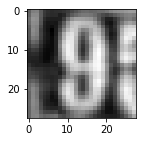

9


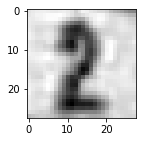

2


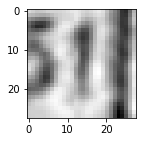

1


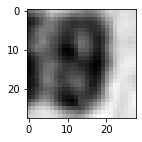

9


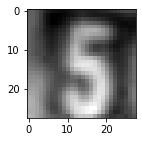

5


In [34]:
plt.figure(figsize=(2,2))
plt.imshow(x_test[3].reshape(28,28),cmap="gray")
plt.show()
print(np.argmax(model.predict(x_test[3].reshape(1,28,28,1))))


plt.figure(figsize=(2,2))
plt.imshow(x_test[2].reshape(28,28),cmap="gray")
plt.show()
print(np.argmax(model.predict(x_test[2].reshape(1,28,28,1))))


plt.figure(figsize=(2,2))
plt.imshow(x_test[33].reshape(28,28),cmap="gray")
plt.show()
print(np.argmax(model.predict(x_test[33].reshape(1,28,28,1))))


plt.figure(figsize=(2,2))
plt.imshow(x_test[59].reshape(28,28),cmap="gray")
plt.show()
print(np.argmax(model.predict(x_test[59].reshape(1,28,28,1))))


plt.figure(figsize=(2,2))
plt.imshow(x_test[36].reshape(28,28),cmap="gray")
plt.show()
print(np.argmax(model.predict(x_test[36].reshape(1,28,28,1))))

# Part 7: kNN

In [35]:
mnist = datasets.load_digits()
 
# take the MNIST data and construct the training and testing split, using 75% of the
# data for training and 25% for testing
(trainData, testData, trainLabels, testLabels) = train_test_split(np.array(mnist.data),
	mnist.target, test_size=0.25, random_state=42)
 
# now, let's take 10% of the training data and use that for validation
(trainData, valData, trainLabels, valLabels) = train_test_split(trainData, trainLabels,
	test_size=0.1, random_state=84)
 
# show the sizes of each data split
print("training data points: {}".format(len(trainLabels)))
print("validation data points: {}".format(len(valLabels)))
print("testing data points: {}".format(len(testLabels)))

training data points: 1212
validation data points: 135
testing data points: 450


In [36]:
# initialize the values of k for our k-Nearest Neighbor classifier along with the
# list of accuracies for each value of k
kVals = range(1, 30, 2)
accuracies = []
 
# loop over various values of `k` for the k-Nearest Neighbor classifier
for k in range(1, 30, 2):
	# train the k-Nearest Neighbor classifier with the current value of `k`
	model = KNeighborsClassifier(n_neighbors=k)
	model.fit(trainData, trainLabels)
 
	# evaluate the model and update the accuracies list
	score = model.score(valData, valLabels)
	print("k=%d, accuracy=%.2f%%" % (k, score * 100))
	accuracies.append(score)
 
# find the value of k that has the largest accuracy
i = int(np.argmax(accuracies))
print("k=%d achieved highest accuracy of %.2f%% on validation data" % (kVals[i],
	accuracies[i] * 100))

k=1, accuracy=99.26%
k=3, accuracy=99.26%
k=5, accuracy=99.26%
k=7, accuracy=99.26%
k=9, accuracy=99.26%
k=11, accuracy=99.26%
k=13, accuracy=99.26%
k=15, accuracy=99.26%
k=17, accuracy=98.52%
k=19, accuracy=98.52%
k=21, accuracy=97.78%
k=23, accuracy=97.04%
k=25, accuracy=97.78%
k=27, accuracy=97.04%
k=29, accuracy=97.04%
k=1 achieved highest accuracy of 99.26% on validation data


In [37]:
# re-train our classifier using the best k value and predict the labels of the
# test data
model = KNeighborsClassifier(n_neighbors=kVals[i])
model.fit(trainData, trainLabels)
predictions = model.predict(testData)
 
# show a final classification report demonstrating the accuracy of the classifier
# for each of the digits
print("EVALUATION ON TESTING DATA")
print(classification_report(testLabels, predictions))

EVALUATION ON TESTING DATA
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        43
           1       0.95      1.00      0.97        37
           2       1.00      1.00      1.00        38
           3       0.98      0.98      0.98        46
           4       0.98      0.98      0.98        55
           5       0.98      1.00      0.99        59
           6       1.00      1.00      1.00        45
           7       1.00      0.98      0.99        41
           8       0.97      0.95      0.96        38
           9       0.96      0.94      0.95        48

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



In [38]:
# loop over a few random digits
for i in list(map(int, np.random.randint(0, high=len(testLabels), size=(5,)))):
	# grab the image and classify it
	image = testData[i]
	prediction = model.predict(image.reshape(1, -1))[0]
 
	# convert the image for a 64-dim array to an 8 x 8 image compatible with OpenCV,
	# then resize it to 32 x 32 pixels so we can see it better
	image = image.reshape((8, 8)).astype("uint8")
	image = exposure.rescale_intensity(image, out_range=(0, 255))
	image = imutils.resize(image, width=32, inter=cv2.INTER_CUBIC)
 
	# show the prediction
	print("I think that digit is: {}".format(prediction))
	cv2.imshow("Image", image)
	cv2.waitKey(0)

I think that digit is: 1
I think that digit is: 6
I think that digit is: 2
I think that digit is: 2
I think that digit is: 4
